<a href="https://colab.research.google.com/github/AmalaRaju/DDDS-Projects/blob/main/Project5_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing



This project will give you practical experience using Natural Language Processing techniques. This project is in three parts:
- in part 1) you will use a dataset in a CSV file
- in part 2) you will use the Wikipedia API to directly access content
on Wikipedia.
- in part 3) you will make your notebook interactive


### Part 1)



- The CSV file is available at https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv
- The file contains a list of famous people and a brief overview.
- The goal of part 1) is to ...
  1. Pick one person from the list ( the target person ) and output 10 other people who's overview are "closest" to the target person in a Natural Language Processing sense
  1. Also output the sentiment of the overview of the target person



In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import ipywidgets as widgets
from IPython.display import display, clear_output
pd.options.display.max_columns = 100

In [25]:
df=pd.read_csv('https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv')

In [26]:
df.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [27]:
df.shape

(42786, 3)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42786 entries, 0 to 42785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     42786 non-null  object
 1   name    42786 non-null  object
 2   text    42786 non-null  object
dtypes: object(3)
memory usage: 1002.9+ KB


In [29]:
df['name'].unique()

array(['Digby Morrell', 'Alfred J. Lewy', 'Harpdog Brown', ...,
       'Eduardo Lara', 'Tatiana Faberg%C3%A9', 'Kenneth Thomas'],
      dtype=object)

In [30]:
# Fetching rows with '%' in 'name' column
filtered_df = df[df['name'].str.contains('%', na=False)]
print(filtered_df)

                                                     URI  \
35     <http://dbpedia.org/resource/Freimut_B%C3%B6rn...   
36     <http://dbpedia.org/resource/Th%C3%BCring_Br%C...   
73     <http://dbpedia.org/resource/Marcel_J._Melan%C...   
85     <http://dbpedia.org/resource/Zvonimir_Juri%C4%87>   
122    <http://dbpedia.org/resource/Se%C3%A1n_%C3%93g...   
...                                                  ...   
42724   <http://dbpedia.org/resource/Jos%C3%A9_Higueras>   
42732  <http://dbpedia.org/resource/Ole_Gunnar_Solskj...   
42733  <http://dbpedia.org/resource/Gerd_Gr%C3%B8nvol...   
42746  <http://dbpedia.org/resource/Floria_M%C3%A1rquez>   
42784  <http://dbpedia.org/resource/Tatiana_Faberg%C3...   

                                        name  \
35                      Freimut B%C3%B6rngen   
36                    Th%C3%BCring Br%C3%A4m   
73                   Marcel J. Melan%C3%A7on   
85                       Zvonimir Juri%C4%87   
122    Se%C3%A1n %C3%93g %C3%93 hAilp%C

Let's clean the name column since some of it contains some unwanted charaters.

In [31]:
# Making a copy of 'original_column'
df['copied_name'] = df['name'].copy()

In [32]:
df.head()

,URI,name,text,copied_name
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,Digby Morrell
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,Alfred J. Lewy
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,Harpdog Brown
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,Franz Rottensteiner
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,G-Enka


In [33]:
def clean_name(name):
    if pd.isnull(name):
        return name
    # Remove only uppercase letters and digits immediately after a '%' symbol
    name = re.sub(r'%[A-Z0-9]+', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

# Apply the function to the 'name' column
df['name'] = df['name'].apply(clean_name)

Let's check if the name column is processed correctly

In [34]:
# Fetching rows with '%' in 'column_name'
filtered_df = df[df['copied_name'].str.contains('%', na=False)]
print(filtered_df)

                                                     URI                name  \
35     <http://dbpedia.org/resource/Freimut_B%C3%B6rn...      Freimut Brngen   
36     <http://dbpedia.org/resource/Th%C3%BCring_Br%C...          Thring Brm   
73     <http://dbpedia.org/resource/Marcel_J._Melan%C...   Marcel J. Melanon   
85     <http://dbpedia.org/resource/Zvonimir_Juri%C4%87>       Zvonimir Juri   
122    <http://dbpedia.org/resource/Se%C3%A1n_%C3%93g...        Sen g hAilpn   
...                                                  ...                 ...   
42724   <http://dbpedia.org/resource/Jos%C3%A9_Higueras>        Jos Higueras   
42732  <http://dbpedia.org/resource/Ole_Gunnar_Solskj...  Ole Gunnar Solskjr   
42733  <http://dbpedia.org/resource/Gerd_Gr%C3%B8nvol...   Gerd Grnvold Saue   
42746  <http://dbpedia.org/resource/Floria_M%C3%A1rquez>       Floria Mrquez   
42784  <http://dbpedia.org/resource/Tatiana_Faberg%C3...      Tatiana Faberg   

                                       

In [35]:
# Step 1: Bag of Words (BoW)
count_vect = CountVectorizer(stop_words='english')
X_counts = count_vect.fit_transform(df['text'])

# Step 2: TF-IDF weighting
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

# Step 3: Select the target person
target_name = "Grant Nelson"
target_index = df[df['name'] == target_name].index[0]

# Step 4: Fit KNN model
knn = NearestNeighbors(n_neighbors=11, metric='cosine')  # 11 to include the target
knn.fit(X_tfidf)

# Step 5: Find nearest neighbors
distances, indices = knn.kneighbors(X_tfidf[target_index])

# Step 6: Output top 10 similar people (excluding the target person)
similar_people = []
for i, idx in enumerate(indices[0]):
    if idx != target_index:
        similarity = 1 - distances[0][i]  # convert cosine distance to similarity
        similar_people.append((df.iloc[idx]['name'], similarity))

# Step 7: Sentiment Analysis
target_text = df.iloc[target_index]['text']
sentiment = TextBlob(target_text).sentiment

# Final Output
print("Target Person:", target_name)
print("Sentiment of Overview:")
print(f"  Polarity: {sentiment.polarity:.3f}, Subjectivity: {sentiment.subjectivity:.3f}\n")

print("Top 10 Most Similar People (TF-IDF + KNN):")
for name, sim in similar_people[:10]:
    print(f"  {name} (Similarity Score: {sim:.4f})")

Target Person: Grant Nelson
Sentiment of Overview:
  Polarity: 0.247, Subjectivity: 0.477

Top 10 Most Similar People (TF-IDF + KNN):
  David Nelson (electronic sports player) (Similarity Score: 0.1233)
  John Nelson (conductor) (Similarity Score: 0.1173)
  Sammy Nelson (Similarity Score: 0.1164)
  Mike Nelson (politician) (Similarity Score: 0.1153)
  Tyrone Nelson (Similarity Score: 0.1102)
  Ben Nelson (footballer) (Similarity Score: 0.1102)
  Jeff Nelson (baseball) (Similarity Score: 0.1091)
  Nelson Quan (Similarity Score: 0.1083)
  Chris Grayston (Similarity Score: 0.1025)
  Roger Nelson (baseball) (Similarity Score: 0.1021)


### Part 2)



- For the same target person that you chose in Part 1), use the Wikipedia API to access the whole content of the target person's Wikipedia page.
- The goal of Part 2) is to ...
  1. Print out the text of the Wikipedia article for the target person
  1. Determine the sentiment of the text of the Wikipedia page for the target person
  1. Collect the text of the Wikipedia pages from the 10 nearest neighbors from Part 1)
  1. Determine the nearness ranking of these 10 people to your target person based on their entire Wikipedia page
  1. Compare, i.e. plot,  the nearest ranking from Step 1) with the Wikipedia page nearness ranking.  A difference of the rank is one means of comparison.



In [36]:
%%capture
!pip3 install wikipedia-api
import wikipediaapi

Print out the text of the Wikipedia article for the target person

In [37]:
target_title = 'Grant Nelson (DJ) '
wikip = wikipediaapi.Wikipedia('foobar')
page_ex = wikip.page(target_title)
wiki_text = page_ex.text
wiki_text

'Grant Nelson (born April 1971), also known as Wishdokta, Bump & Flex and N\'n\'G, is an English DJ, remixer and record producer.\n\nBiography\nIn the 1990s, inspired by producers such as Masters at Work, MK and Eddie Perez, he played an important role in the development of the UK garage genre, being heralded as the "Godfather of UK Garage".\nIn 2013, Nelson appeared alongside many other garage pioneers in a documentary exploring the legacy of UK garage, Rewind 4Ever: The History of UK Garage.\nHit singles on the UK charts as Bump & Flex include "Long Time Coming" (UK #73, UK Dance #3) and "Got Myself Together" (UK #84, UK Dance #3), and as one half of N\'n\'G, he scored a No. 12 and No. 1 Dance hit with "Right Before My Eyes" in 2000.\nPopular Bump & Flex remixes include Mis-Teeq\'s "B with Me" (UK #5), James Brown\'s "Funk on Ah Roll" (UK #40, UK Dance #1), Indo\'s "R U Sleeping" (UK #31, UK Dance #3) and the Steppers Dub of Nelson\'s "Step 2 Me" (featuring Jean McClain; UK #92, UK D

In [38]:
wiki_text_clean = (
  wiki_text
  .lower()
  .replace("\n"," ")
  .replace("\'s",'')
  .replace('\'','')
  .replace("(", "")
  .replace(")", "")
  .replace('"', "")
)
wiki_text_clean

'grant nelson born april 1971, also known as wishdokta, bump & flex and nng, is an english dj, remixer and record producer.  biography in the 1990s, inspired by producers such as masters at work, mk and eddie perez, he played an important role in the development of the uk garage genre, being heralded as the godfather of uk garage. in 2013, nelson appeared alongside many other garage pioneers in a documentary exploring the legacy of uk garage, rewind 4ever: the history of uk garage. hit singles on the uk charts as bump & flex include long time coming uk #73, uk dance #3 and got myself together uk #84, uk dance #3, and as one half of nng, he scored a no. 12 and no. 1 dance hit with right before my eyes in 2000. popular bump & flex remixes include mis-teeq b with me uk #5, james brown funk on ah roll uk #40, uk dance #1, indo r u sleeping uk #31, uk dance #3 and the steppers dub of nelson step 2 me featuring jean mcclain; uk #92, uk dance #7.  references external links grantnelson.co.uk g

In [39]:
wiki_blob = TextBlob(wiki_text_clean)
wiki_blob

TextBlob("grant nelson born april 1971, also known as wishdokta, bump & flex and nng, is an english dj, remixer and record producer.  biography in the 1990s, inspired by producers such as masters at work, mk and eddie perez, he played an important role in the development of the uk garage genre, being heralded as the godfather of uk garage. in 2013, nelson appeared alongside many other garage pioneers in a documentary exploring the legacy of uk garage, rewind 4ever: the history of uk garage. hit singles on the uk charts as bump & flex include long time coming uk #73, uk dance #3 and got myself together uk #84, uk dance #3, and as one half of nng, he scored a no. 12 and no. 1 dance hit with right before my eyes in 2000. popular bump & flex remixes include mis-teeq b with me uk #5, james brown funk on ah roll uk #40, uk dance #1, indo r u sleeping uk #31, uk dance #3 and the steppers dub of nelson step 2 me featuring jean mcclain; uk #92, uk dance #7.  references external links grantnelso

Let's determine the sentiment of the text of the Wikipedia page for the target person(Grant Nelson)

In [40]:
wiki_blob.sentiment

Sentiment(polarity=0.13127705627705627, subjectivity=0.407034632034632)

In [41]:
neighbor_titles = [
   "David Nelson (electronic sports player)",
  "John Nelson (conductor)",
  "Sammy Nelson",
  "Michael R. Nelson",
  "Tyrone Nelson",
  "Ben Nelson (Australian footballer)",
  "Jeff Nelson (pitcher)",
  "Nelson Quan",
  "Chris Grayston",
  "Roger Nelson (baseball)"
]
# Text cleaning function
def clean_wikipedia_text(text):
    text = re.sub(r'\[\d+\]', '', text)
    text = re.split(r'==\s*References\s*==', text)[0]
    text = re.sub(r'==+.*?==+', '', text)
    return re.sub(r'\s+', ' ', text).strip()

# Fetch and clean pages
titles = [target_title] + neighbor_titles
texts = []
valid_titles = []

for title in titles:
    page = wikip.page(title)
    if page.exists():
        cleaned = clean_wikipedia_text(page.text)
        texts.append(cleaned)
        valid_titles.append(title)
    else:
        print(f"Page not found: {title}")

# Compute TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(texts)

# Compute cosine similarities
cos_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])[0]  # similarities to target

# Rank by similarity
ranked = sorted(zip(valid_titles[1:], cos_sim), key=lambda x: x[1], reverse=True)

# Print first 500 characters of each cleaned article
print("\n--- First 500 Characters of Each Cleaned Article ---\n")
for title, text in zip(valid_titles, texts):
    print(f"\n--- {title} ---\n")
    print(text[:500])  # Print first 500 characters


# Print ranked results
print("\n--- Similarity Ranking to Target: Grant Nelson (DJ) ---\n")
for i, (title, score) in enumerate(ranked, 1):
    print(f"{i}. {title}: {score:.4f}")


--- First 500 Characters of Each Cleaned Article ---


--- Grant Nelson (DJ)  ---

Grant Nelson (born April 1971), also known as Wishdokta, Bump & Flex and N'n'G, is an English DJ, remixer and record producer. Biography In the 1990s, inspired by producers such as Masters at Work, MK and Eddie Perez, he played an important role in the development of the UK garage genre, being heralded as the "Godfather of UK Garage". In 2013, Nelson appeared alongside many other garage pioneers in a documentary exploring the legacy of UK garage, Rewind 4Ever: The History of UK Garage. Hit singl

--- David Nelson (electronic sports player) ---

David Nelson (born January 18, 1974, in New Hampshire) is an American arcade video game player who holds world record high scores listed in the 2008 Guinness World Records-Gamer's Edition. David Nelson has broken many world records while competing in classic arcade championships at the Funspot Family Fun Center in Weirs Beach, New Hampshire. As of 2008, David Nel

Compare the nearest ranking from Part 1 with the Wikipedia page nearness ranking.

In [42]:
# Assuming you have this data-based ranking from Part 1 (replace with actual data)
data_ranking = [
  "David Nelson (electronic sports player)",
  "John Nelson (conductor)",
  "Sammy Nelson",
  "Michael R. Nelson",
  "Tyrone Nelson",
  "Ben Nelson (Australian footballer)",
  "Jeff Nelson (pitcher)",
  "Nelson Quan",
  "Chris Grayston",
  "Roger Nelson (baseball)"
]

# The Wikipedia-based ranking we calculated previously (from ranked list)
wiki_ranking = [title for title, _ in ranked]

# Calculate the rank difference
rank_differences = {}

for person in data_ranking:
    if person in wiki_ranking:
        data_rank = data_ranking.index(person) + 1
        wiki_rank = wiki_ranking.index(person) + 1
        rank_difference = abs(data_rank - wiki_rank)
        rank_differences[person] = rank_difference
    else:
        rank_differences[person] = "Not in Wikipedia Ranking"

# Display rank differences
print("\n--- Rank Differences ---\n")
for person, diff in rank_differences.items():
    print(f"{person}: Difference = {diff}")



--- Rank Differences ---

David Nelson (electronic sports player): Difference = 6
John Nelson (conductor): Difference = 3
Sammy Nelson: Difference = 5
Michael R. Nelson: Difference = 6
Tyrone Nelson: Difference = 1
Ben Nelson (Australian footballer): Difference = 3
Jeff Nelson (pitcher): Difference = 5
Nelson Quan: Difference = 1
Chris Grayston: Difference = 8
Roger Nelson (baseball): Difference = 6


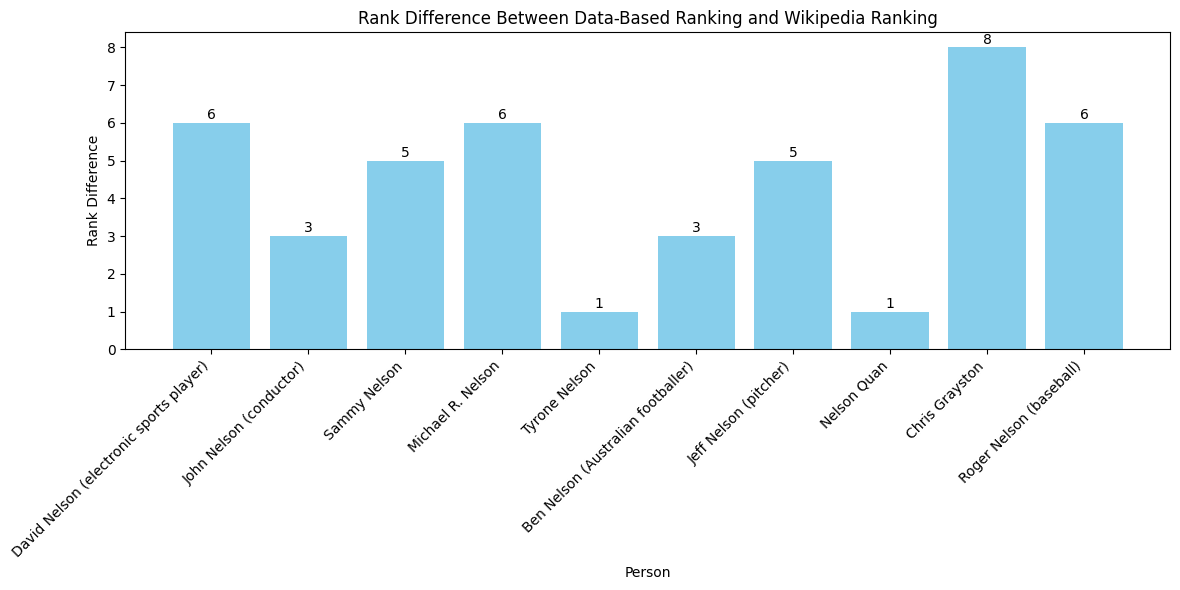

In [43]:
# Prepare data for visualization
names = list(rank_differences.keys())
differences = list(rank_differences.values())

# Plotting the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(names, differences, color='skyblue')
plt.title("Rank Difference Between Data-Based Ranking and Wikipedia Ranking")
plt.xlabel("Person")
plt.ylabel("Rank Difference")
plt.xticks(rotation=45, ha='right')

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f"{int(height)}",
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()


### Part 3)


Make an interactive notebook where a user can choose or enter a name and the notebook displays the 10 closest individuals.

In addition to presenting the project slides, at the end of the presentation each student will demonstrate their code using a famous person suggested by the other students that exists in the DBpedia set.


In [44]:
!curl -s https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv | wc -l

42786


Make an interactive notebook where a user can choose or enter a name and the notebook displays the 10 closest individuals.

In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['text'])

# KNN Model
knn = NearestNeighbors(n_neighbors=11, metric='cosine')
knn.fit(tfidf_matrix)

# Widgets
input_box = widgets.Text(
    value='',
    description='Enter Name:',
    placeholder='Type a name...'
)
search_button = widgets.Button(
    description="Search",
    button_style="success"
)
output_area = widgets.Output()

# Function to find similar people
def find_similar_people(target_name):
    with output_area:
        clear_output()
        if target_name not in df['name'].values:
            print(f"'{target_name}' not found in the list. Please enter a valid name.")
            return

        target_index = df[df['name'] == target_name].index[0]
        distances, indices = knn.kneighbors(tfidf_matrix[target_index])

        print(f"\nTarget Person: {target_name}")
        print("\nTop 10 Most Similar People:")
        for i, idx in enumerate(indices[0]):
            if idx != target_index:
                similarity = 1 - distances[0][i]
                print(f"  {df.iloc[idx]['name']} (Similarity Score: {similarity:.4f})")

# Trigger search on button click
def on_button_click(b):
    find_similar_people(input_box.value)

search_button.on_click(on_button_click)

# Display input, button, and output area
display(widgets.VBox([input_box, search_button, output_area]))